In [1]:
!pip install --upgrade pip
!pip install textgenrnn
!pip3 install --upgrade tensorflow keras
# !conda update
# !conda install tensorflow keras
# nvcc --version
!pip3 install --upgrade scipy
!pip install --upgrade six
!pip install --upgrade grpcio

Requirement already up-to-date: pip in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (20.0.2)
Requirement already up-to-date: tensorflow in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (2.1.0)
Requirement already up-to-date: keras in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (2.3.1)


Requirement already up-to-date: scipy in /Users/birdshaw/anaconda3/lib/python3.7/site-packages (1.4.1)
ERROR: astroid 2.3.1 requires typed-ast<1.5,>=1.4.0; implementation_name == "cpython" and python_version < "3.8", which is not installed.
ERROR: astroid 2.3.1 has requirement six==1.12, but you'll have six 1.14.0 which is incompatible.
  Attempting uninstall: six
    Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
     |████████████████████████████████| 2.5 MB 2.2 MB/s eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.27.1
    Uninstalling grpcio-1.27.1:
      Successfully uninstalled grpcio-1.27.1


In [518]:
import pandas as pd
import numpy as np
import unicodedata
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams

from textgenrnn import textgenrnn

# from tensorflow.keras.layers import UnifiedLSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional

In [241]:
df = pd.read_csv('Data/drinksandcocktails_1.0.9.csv', escapechar='\\')

In [242]:
df_drink = df[(df['d_cat'] == 'Ordinary Drink') | (df['d_cat'] == 'Cocktail')]

In [243]:
df_drink = df_drink.dropna(axis='index')

In [244]:
df_drink = df_drink.dropna(axis='index')
df_drink = df[(df['d_cat'] == 'Ordinary Drink') | (df['d_cat'] == 'Cocktail')]
df_drink['ingredients'] = (df_drink['d_ingredients'].str.split('|').str.join(', ').tolist())

In [293]:
df_drink['d_shopping'] = df_drink['d_shopping'].str.split('|')

In [298]:
df_drink['d_shopping'].head().values

array([list(['Vodka', 'Southern Comfort', 'Grand Marnier', 'Pineapple juice']),
       list(['Jack Daniels', 'Vodka', 'Dr. Pepper', 'Sugar', 'Cherry']),
       list(['Creme de Cacao', 'Vodka']),
       list(['Dark rum', 'Light rum', 'Vodka', 'Orange juice']),
       list(['Gin', 'Light rum', 'Tequila', 'Triple sec', 'Vodka', 'Coca-Cola', 'Sweet and sour', 'Bitters', 'Lemon'])],
      dtype=object)

## Some EDA (not much needed tbh)

In [390]:
ing = 0

for idx, row in df_drink.iterrows():
    ing += len(df_drink.loc[idx, 'd_shopping'])
    
        

In [427]:
df_uniq = df_drink.copy()
df_uniq.d_ingredients = df_uniq.d_ingredients.str.split('|')
df_uniq['d_ingredients'].unique

<bound method Series.unique of 1        [1/2 oz Vodka, 1 1/2 oz Southern Comfort, 1/2 ...
4        [1 shot Jack Daniels, 1 shot Vodka, 6 shots Dr...
6                  [1 oz white Creme de Cacao, 1 oz Vodka]
10       [1 shot Dark rum, 2 shots Light rum, 1 shot Vo...
12       [1/2 oz Gin, 1/2 oz Light rum, 1/2 oz Tequila,...
                               ...                        
16346    [1/2 oz light rum, 3/4 oz gold rum, 1/4 oz apr...
16347    [1 oz creme de cassis, 1 oz vodka, 1/2 oz peac...
16348    [1 oz creme de cacao, 1 oz amaretto almond liq...
16349    [2 oz tequila, 1/2 oz Galliano(R) herbal lique...
16350    [1 oz dark rum, 1 oz dark creme de cacao, 1/2 ...
Name: d_ingredients, Length: 12294, dtype: object>

In [576]:
# Finding max and minimum length of ingredients used in cocktails

df_uniq['d_shopping'].map(len).min()

1

In [574]:
df_uniq

,id,d_name,d_cat,d_alcohol,d_glass,d_ingredients,d_instructions,d_shopping,ingredients
1,2,'57 Chevy,Cocktail,Alcoholic,Cocktail glass,"[1/2 oz Vodka, 1 1/2 oz Southern Comfort, 1/2 ...",Shake and serve.,"[Vodka, Southern Comfort, Grand Marnier, Pinea...","15.0 ml Vodka, 45.0 ml Southern Comfort, 15.0 ..."
4,5,187 URge,Cocktail,Alcoholic,Any Glass,"[1 shot Jack Daniels, 1 shot Vodka, 6 shots Dr...",Mix together and stir it is good,"[Jack Daniels, Vodka, Dr. Pepper, Sugar, Cherry]","44.0 ml Jack Daniels, 44.0 ml Vodka, 264.0 mls..."
6,7,'57 Chevy with a White License Plate,Cocktail,Alcoholic,Highball glass,"[1 oz white Creme de Cacao, 1 oz Vodka]",1. Fill a rocks glass with ice 2.add white cre...,"[Creme de Cacao, Vodka]","30.0 ml white Creme de Cacao, 30.0 ml Vodka"
10,11,155 Belmont,Cocktail,Alcoholic,White wine glass,"[1 shot Dark rum, 2 shots Light rum, 1 shot Vo...",Blend with ice. Serve in a wine glass. Garnish...,"[Dark rum, Light rum, Vodka, Orange juice]","44.0 ml Dark rum, 88.0 mls Light rum, 44.0 ml ..."
12,13,3-Mile Long Island Iced Tea,Ordinary Drink,Alcoholic,Any Glass,"[1/2 oz Gin, 1/2 oz Light rum, 1/2 oz Tequila,...",Fill 14oz glass with ice and alcohol. Fill 2/3...,"[Gin, Light rum, Tequila, Triple sec, Vodka, C...","15.0 ml Gin, 15.0 ml Light rum, 15.0 ml Tequil..."
...,...,...,...,...,...,...,...,...,...
16346,16347,Zombie (UK Style),Cocktail,Alcoholic,Hurricane Glass,"[1/2 oz light rum, 3/4 oz gold rum, 1/4 oz apr...",Based on original recipe and is incredibly tas...,"[light rum, gold rum, apricot brandy, triple s...","15.0 ml light rum, 22.5 ml gold rum, 7.5 ml ap..."
16347,16348,Zone 23,Cocktail,Alcoholic,Red Wine Glass,"[1 oz creme de cassis, 1 oz vodka, 1/2 oz peac...",Invented by the owner and served as the signat...,"[creme de cassis, vodka, peach schnapps, cranb...","30.0 ml creme de cassis, 30.0 ml vodka, 15.0 m..."
16348,16349,Zorro's Revenge,Cocktail,Alcoholic,Cocktail Glass,"[1 oz creme de cacao, 1 oz amaretto almond liq...","Similar to the shot drink ""abortion"". Zorro's ...","[creme de cacao, amaretto almond liqueur, Bail...","30.0 ml creme de cacao, 30.0 ml amaretto almon..."
16349,16350,Zultry Zoe,Cocktail,Alcoholic,Irish Coffee Cup,"[2 oz tequila, 1/2 oz Galliano(R) herbal lique...","Pour tequila, galliano and Mexican hot chocola...","[tequila, Galliano(R) herbal liqueur, Mexican ...","60.0 ml tequila, 15.0 ml Galliano(R) herbal li..."


In [392]:
df_drink.shape

(12294, 9)

In [405]:
print('Average number of ingredients in a cocktail: {:.1f}'.format(ing / df_drink.shape[0]))

Average number of ingredients in a cocktail: 4.0


In [331]:
# Used to get total number of ingredients used

d = {}

for idx, row in df_drink.iterrows():
    lst = df_drink.loc[idx, 'd_shopping']
#     lst = lst.lower()
    for j in range(len(row['d_shopping'])):
        if lst[j].lower() not in d:
            d[lst[j].lower()] = 1
        else:
            d[lst[j].lower()] += 1

In [336]:
# Turn dictionary to dataframe, sort, then plot

df_items = pd.DataFrame.from_dict(data = d, orient = 'index')

df_items = df_items.sort_values(by = 0, ascending=False)

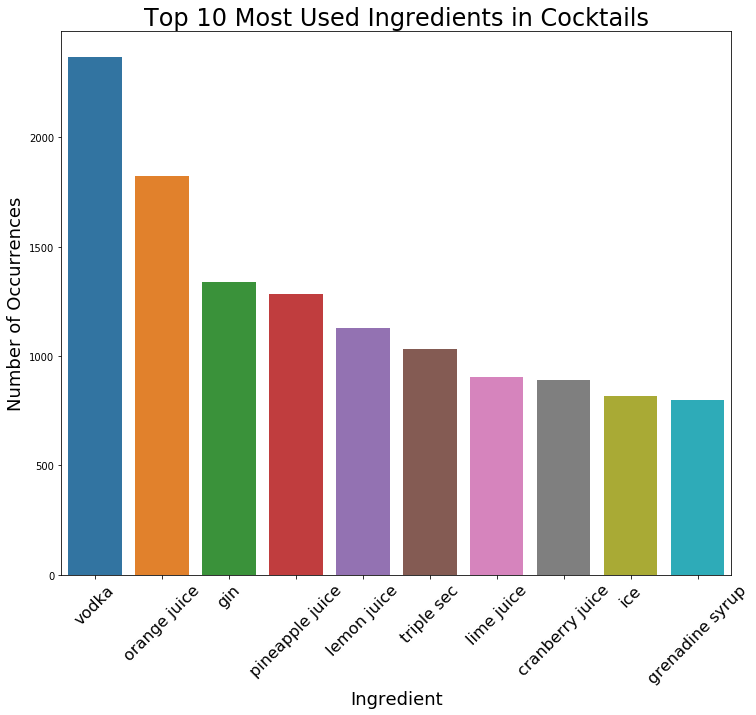

In [386]:

plt.figure(figsize=(12, 10))
sns.barplot(df_items.head(10).index, df_items[0].head(10))
plt.title('Top 10 Most Used Ingredients in Cocktails', fontsize = 24)
plt.ylabel('Number of Occurrences', fontsize=18)
plt.xlabel('Ingredient', fontsize=18)
plt.xticks(rotation=45, fontsize= 16)

plt.savefig('ingredient.png')

In [356]:
df_items = df_items.sort_values(by = 0, ascending=False)


In [569]:
df_items

,0
vodka,2366
orange juice,1825
gin,1339
pineapple juice,1285
lemon juice,1130
...,...
tamarind,1
chile piqions,1
peruvian pisco brandy,1
elderflower cordial,1


In [582]:
df_unreg = df.copy()

df_unreg = df_unreg.dropna(axis='index')
df_unreg = df_unreg[(df_unreg['d_cat'] == 'Ordinary Drink') | (df_unreg['d_cat'] == 'Cocktail')]
df_unreg['ingredients'] = (df_unreg['d_ingredients'].str.split('|').str.join(', ').tolist())

df_unreg = df_unreg.sample(4000)

df_unreg = df_unreg.loc[:, ['d_name', 'ingredients']]

df_unreg.to_csv('unreg_drinks.txt',encoding='utf-8', header=None, index=False)

In [583]:
df_unreg

,d_name,ingredients
14717,Peach Puff Martini,"2 oz Smirnoff(R) Raspberry Twist vodka, 2 oz D..."
3695,Milky Way Martini,"2 oz Vanilla vodka, 2 oz Chocolate liqueur, 1 ..."
14879,Pink Bliss,"1 oz Smirnoff(R) vodka, 5 oz Schweppes(R) pink..."
16014,The Rapture,"2 oz Bacardi(R) gold rum, 2 oz Absolut(R) vodk..."
11138,Event Horizon,"1 scoopmint chocolate ice cream, 1 shot pepper..."
...,...,...
10202,Cocopolitan,"1 1/4 oz Burnett's(R) coconut vodka, 1/2 oz Co..."
4253,Pimm's Royal,"1 1/2 oz Pimm's No. 1, Champagne, Lemon peel, ..."
13841,Mexican Chocolate Martini,"2 oz3 Olives chocolate vodka, 1/2 oz Godiva(R)..."
12653,Italian Crown,"2 oz Crown Royal(R) Canadian whisky, 2 oz amar..."


# Regularize the Data and turn to text

In [246]:
df_drink['ingredients'] = df_drink['ingredients'].replace(regex = {'1/2': '0.5','1/4': '0.25', '3/10': '0.3','2/10': '0.2','1/10': '0.1','1/8': '0.125',
                                     '1/3': '0.3','2/3': '0.6','3/4': '0.75','1\s0.5': '1.5','1\s0.25': '1.25',
                                     '1\s0.75': '1.75', '2\s0.25': '2.25', '2\s0.3':'2.3',  '2\s0.5': '2.5', '2\s0.75': '2.75','1-0.5': '1.5', '2 .6': '2.6','3/4': '0.75',
                                     '0.5-1|0.5 - 1': '0.75','1-2': '1.5','1 or 2': '1.5','1.5 - 2': '1.75', '1-2|1 - 2': '1.5',
                                     '1-1.5|1 - 1.5': '1.25','4-6': '5','6-7|6 - 7': '6.5','2-3|2 - 3': '2.5',
                                     '2.5-3|2.5 - 3': '2.75','3-4|3 - 4': '3.5','4-5|4 - 5': '4.5','5-7|5 - 7': '6',
                                     '2-4|2 - 4': '3','8-12|8 - 12': '10','7-8|7 - 8': '7.5','1-3|1 - 3': '2',
                                     '6-8|6 - 8': '7','8-10|8 - 10':'9','10-12|10 - 12': '11','6-10|6 - 10': '8',
                                     '1.5-2|1.5 - 2': '1.75','3-6|3 - 6': '4.5','3-5|3 - 5': '4','5-6|5 - 6': '5.5',
                                     '9-10|9 - 10': '9.5','5-10|5 - 10': '7.5','12-14|12 - 14': '13',
                                     '.75-3/2|.75 - 3/2': '1.125','30-45': '40','cups': 'cup','pints': 'pint',
                                     'quarts': 'quart','gallons': 'gallon', 'tblsp': 'tbsp'})

In [247]:
df_drink.head(10)

,id,d_name,d_cat,d_alcohol,d_glass,d_ingredients,d_instructions,d_shopping,ingredients
1,2,'57 Chevy,Cocktail,Alcoholic,Cocktail glass,1/2 oz Vodka|1 1/2 oz Southern Comfort|1/2 oz ...,Shake and serve.,Vodka|Southern Comfort|Grand Marnier|Pineapple...,"0.5 oz Vodka, 1.5 oz Southern Comfort, 0.5 oz ..."
4,5,187 URge,Cocktail,Alcoholic,Any Glass,1 shot Jack Daniels|1 shot Vodka|6 shots Dr. P...,Mix together and stir it is good,Jack Daniels|Vodka|Dr. Pepper|Sugar|Cherry,"1 shot Jack Daniels, 1 shot Vodka, 6 shots Dr...."
6,7,'57 Chevy with a White License Plate,Cocktail,Alcoholic,Highball glass,1 oz white Creme de Cacao|1 oz Vodka,1. Fill a rocks glass with ice 2.add white cre...,Creme de Cacao|Vodka,"1 oz white Creme de Cacao, 1 oz Vodka"
10,11,155 Belmont,Cocktail,Alcoholic,White wine glass,1 shot Dark rum|2 shots Light rum|1 shot Vodka...,Blend with ice. Serve in a wine glass. Garnish...,Dark rum|Light rum|Vodka|Orange juice,"1 shot Dark rum, 2 shots Light rum, 1 shot Vod..."
12,13,3-Mile Long Island Iced Tea,Ordinary Drink,Alcoholic,Any Glass,1/2 oz Gin|1/2 oz Light rum|1/2 oz Tequila|1/2...,Fill 14oz glass with ice and alcohol. Fill 2/3...,Gin|Light rum|Tequila|Triple sec|Vodka|Coca-Co...,"0.5 oz Gin, 0.5 oz Light rum, 0.5 oz Tequila, ..."
14,15,351 Special,Ordinary Drink,Alcoholic,Coffee mug,1 part Coca-Cola|1 part Gin (Gordon's)|2 splas...,Pour Gordon's Gin and Kronenbourg beer (it MUS...,Coca-Cola|Gin|Beer,"1 part Coca-Cola, 1 part Gin (Gordon's), 2 spl..."
15,16,357 Magnum,Ordinary Drink,Alcoholic,Any Glass,1 oz Vodka (Smirnoff)|1 oz Rum (Captain Morgan...,Pour vodka and rum over ice. Add 7-up and stir...,Vodka|Rum|Amaretto|7-Up,"1 oz Vodka (Smirnoff), 1 oz Rum (Captain Morga..."
16,17,3001,Ordinary Drink,Alcoholic,Collins glass,1 oz Blue Curacao|1 oz Vodka|1/2 oz Tonic wate...,"Combine blue curacao, vodka, tonic water, and ...",Blue Curacao|Vodka|Tonic water|Lime juice|Ice|...,"1 oz Blue Curacao, 1 oz Vodka, 0.5 oz Tonic wa..."
17,18,3rd Wheel,Cocktail,Alcoholic,Margarita Glass,2 parts Alize|1 part Grand Marnier,Chill with ice and pour in glass,Alize|Grand Marnier,"2 parts Alize, 1 part Grand Marnier"
18,19,3rd Street Promanade,Cocktail,Alcoholic,Highball glass,1 1/2 oz Vanilla vodka (Stoli)|1/3 oz Gin|1/3 ...,"In a blender, put in ice, orange juice, vodka,...",Vanilla vodka|Gin|Triple sec|Tequila|Cinnamon ...,"1.5 oz Vanilla vodka (Stoli), 0.3 oz Gin, 0.3 ..."


In [252]:
# Needed to convert all miscellaneous formats of proportions to a uniform format to be later regularized to mls.



def replace_val(row):
    
    # Apply this function to take cleaned dataset and properly convert all measurements to ml.
    
    units = [['oz', 30.], ['gallon', 3785], ['shot', 44], ['liter', 1000], ['quart', 946], ['pint', 473], ['cup', 240], ['jigger', 44], ['tbsp', 18], ['tsp', 6], ['dash', 1], ['cl', 10]]
    num = [0.1, 0.125, 0.2, 0.25, 0.3, 0.5, 0.6, 0.75, 0.8, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.3, 2.5, 2.6, 2.75, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7,
           7.5, 8, 9, 9.5, 10, 11, 12, 13, 16, 30, 40]
    
    for i in units:
        for j in num:
            val = float(j) * float(i[1])
#             val= np.around(val)
            row['ingredients'] = row['ingredients'].replace(f"{j} {i[0]}", f"{val} ml")
    return row

In [250]:
df_drink[df_drink['ingredients'].str.contains('2.25')]

,id,d_name,d_cat,d_alcohol,d_glass,d_ingredients,d_instructions,d_shopping,ingredients
8254,8255,Aperitivo,Cocktail,Alcoholic,Cocktail Glass,2 1/4 oz gin|3/4 oz white sambuca|3 dashes ora...,"Pour gin, sambuca and bitters into a mixing gl...",gin|white sambuca|orange bitters,"2.25 oz gin, 0.75 oz white sambuca, 3 dashes o..."
8672,8673,Batida de Carneval,Cocktail,Alcoholic,Highball Glass,1 oz orange juice|2 1/4 oz mango juice|3/4 oz ...,Pour over crushed ice in a large highball glas...,orange juice|mango juice|Sagatiba Pura,"1 oz orange juice, 2.25 oz mango juice, 0.75 o..."
9386,9387,Brown Betty Punch,Cocktail,Alcoholic,Beer Mug,48 oz(4 bottles) Bass(R) pale ale|12 oz brandy...,"Add the sugar, lemon slices, cloves, cinnamon ...",Bass(R) pale ale|brandy|water|ginger|nutmeg|ci...,"48 oz(4 bottles) Bass(R) pale ale, 12 oz brand..."
10121,10122,Claret Punch,Cocktail,Alcoholic,Punch Bowl,2 cups lemon juice|1 cup superfine sugar|2.25 ...,Stir the lemon juice and sugar togeher in a la...,lemon juice|superfine sugar|claret|brandy|apri...,"2 cup lemon juice, 1 cup superfine sugar, 2.25..."
12152,12153,Harrison Ford,Cocktail,Alcoholic,Highball Glass,1 1/2 oz Kahlua(R) coffee liqueur|3 oz Bailey'...,Pour ingredients over ice in a highball glass....,Kahlua(R) coffee liqueur|Bailey's(R) Irish cre...,"1.5 oz Kahlua(R) coffee liqueur, 3 oz Bailey's..."
12172,12173,Hawaiian Cherry Popper,Cocktail,Alcoholic,Collins Glass,2 1/4 oz Malibu(R) coconut rum|4 1/2 oz cherry...,Pour all ingredients into a collins glass 3/4 ...,Malibu(R) coconut rum|cherry cola|pineapple ju...,"2.25 oz Malibu(R) coconut rum, 4 0.5 oz cherry..."
12350,12351,Hong Kong Smog,Cocktail,Alcoholic,Cocktail Glass,2 1/4 oz Tanqueray(R) gin|3/4 oz Midori(R) mel...,Pour Tanqueray gin and Midori melon liqueur in...,Tanqueray(R) gin|Midori(R) melon liqueur,"2.25 oz Tanqueray(R) gin, 0.75 oz Midori(R) me..."
12358,12359,Hooker,Cocktail,Alcoholic,Cocktail Glass,3/4 oz Alize(R) Gold Passion liqueur|2 1/4 oz ...,Pour Alize Gold Passion and Tropicana simultan...,Alize(R) Gold Passion liqueur|Tropicana(R) fru...,"0.75 oz Alize(R) Gold Passion liqueur, 2.25 oz..."
12736,12737,Jamaica Cooler,Cocktail,Alcoholic,Red Wine Glass,2 1/4 oz dark rum|4 - 5 oz 7-Up(R) soda|2 dash...,Pour the dark rum into a wine goblet and stir ...,dark rum|7-Up(R) soda|orange bitters|lemon jui...,"2.25 oz dark rum, 4.5 oz 7-Up(R) soda, 2 dashe..."
13168,13169,Kronik Margarita,Cocktail,Alcoholic,Margarita Glass,2 1/4 oz tequila|6 oz Kronik(R) energy drink|1...,Ad shot of your favorite favor of tequila over...,tequila|Kronik(R) energy drink|lime,"2.25 oz tequila, 6 oz Kronik(R) energy drink, ..."


In [253]:
# Apply previous function to regularize all measurements and then turn to text file with only names
# and ingredients

df_drink = df_drink.apply(replace_val, axis=1)

df_drink_txt = df_drink.loc[:, ['d_name', 'ingredients']]

df_drink_txt.to_csv('unit_reg_drinks_done.txt',encoding='utf-8', header=None, index=False)

In [447]:
df_drink_sample = df_drink.sample(2000)
df_drink_sample = df_drink_sample.loc[:, ['d_name', 'ingredients']]
df_drink_sample.to_csv('sample_drink_2k.txt', encoding='utf-8', header=None, index = False)

In [445]:
# Begin using textgen module, choose character level as it seems to work better than word level

textgen_dandco= textgenrnn(weights_path='Data/cocktailAI_weights.hdf5', vocab_path= 'Data/cocktailAI_vocab.json', config_path= 'Data/cocktailAI_config.json')
textgen_dandco.generate_to_file(n=10, temperature = 1, destination_path='d_&_co_1.0T.txt')

# textgen_dandco.train_from_file('Data/unit_reg_drinks_2.txt', num_epochs=40, rnn_layers = 5, rnn_size = 128, rnn_bidirectional = True,
#                         max_length = 40, max_words = 10000, dim_embeddings = 100, word_level = False,
#                         train_size = 0.8, drop_out = 0.2, new_model=True, all_growth=True)

100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


# Build my own RNN

In [257]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import time

In [67]:
## Don't use

path_to_file = tf.keras.utils.get_file('unit_reg_drinks_done.txt', 'Data/unit_reg_drinks_2.txt')

NameError: name 'tf' is not defined

In [467]:
## Use

text = open('Data/sample_drink_set.txt', 'rb').read().decode(encoding='utf-8')

In [468]:
text

'O & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.0 ml Gin, 30.0 ml Sweet Vermouth, 1 Olive"\nFar West,"15 ml Brandy, 15 ml Advocaat, 15 ml Dry Vermouth, 1.0 ml Angostura bitters"\nPearl Harbor,"30.0 ml vodka, 15.0 ml melon liqueur, 150.0 ml pineapple juice"\nPassion Zombie,"30.0 ml gold rum, 30.0 ml Jamaican dark rum, 30.0 ml light rum, 30.0 ml 99 Bananas(R) banana schnapps, 15.0 ml 151 proof rum, 15.0 ml grenadine syrup, 15.0 ml lemon juice, 15.0 ml lime juice, 60.0 ml passion-fruit juice, 18.0 mlbrown sugar, 30.0 ml passion-fruit syrup"\nLittle Devil,"30.0 ml dry gin, 30.0 ml rum, 15.0 ml triple sec, 15.0 ml lemon juice"\nThe Haggar,"30.0 ml tequila, lemonade"\nIrish Cocktail,"45.0 ml Irish whiskey, 15.0 ml Pernod(R) licorice liqueur, 1.0 ml maraschino liqueur, 15.0 ml White Curacao liqueur"\nPeach Brandy Julep,"2 fresh mint, 15.0 ml Marie Brizard(R) peach liqueur, 2 sweet, ripe peach, 60.0 ml cognac"\nBust Your Black Nut,"90.0 ml 

In [469]:
# unique values in file

vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

76 unique characters


In [470]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [471]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'O & Tonic,"45' ---- characters mapped to int ---- > [38  1  6  1 43 64 63 58 52 10  3 18 19]


In [472]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

O
 
&
 
T


In [473]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [474]:
for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'O & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.0'
' ml Gin, 30.0 ml Sweet Vermouth, 1 Olive"\nFar West,"15 ml Brandy, 15 ml Advocaat, 15 ml Dry Vermouth,'
' 1.0 ml Angostura bitters"\nPearl Harbor,"30.0 ml vodka, 15.0 ml melon liqueur, 150.0 ml pineapple jui'
'ce"\nPassion Zombie,"30.0 ml gold rum, 30.0 ml Jamaican dark rum, 30.0 ml light rum, 30.0 ml 99 Banana'
's(R) banana schnapps, 15.0 ml 151 proof rum, 15.0 ml grenadine syrup, 15.0 ml lemon juice, 15.0 ml li'


In [475]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [476]:
dataset

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

In [477]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'O & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.'
Target data: ' & Tonic,"45.0 ml Bacardi(R) orange rum, 180.0 ml tonic water, 1 twist orange"\nMartini (Sweet),"30.0'


In [478]:
# Batch size
BATCH_SIZE = 128

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((128, 100), (128, 100)), types: (tf.int64, tf.int64)>

In [479]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 38 ('O')
  expected output: 1 (' ')
Step    1
  input: 1 (' ')
  expected output: 6 ('&')
Step    2
  input: 6 ('&')
  expected output: 1 (' ')
Step    3
  input: 1 (' ')
  expected output: 43 ('T')
Step    4
  input: 43 ('T')
  expected output: 64 ('o')


In [523]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = len(vocab)

# Number of RNN units
rnn_units = 256

In [547]:
# Building a model. Add layers later on to optimize

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')),
    tf.keras.layers.Bidirectional(LSTM(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')),    
    tf.keras.layers.Dense(vocab_size, activation='softmax')])
    return model

In [548]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [549]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(128, 100, 76) # (batch_size, sequence_length, vocab_size)


In [550]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (128, None, 76)           5776      
_________________________________________________________________
bidirectional_54 (Bidirectio (128, None, 512)          681984    
_________________________________________________________________
bidirectional_55 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
bidirectional_56 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
bidirectional_57 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
bidirectional_58 (Bidirectio (128, None, 512)          1574912   
_________________________________________________________________
dense_16 (Dense)             (128, None, 76)         

In [551]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [552]:
sampled_indices

array([66, 11, 20,  9, 47, 17, 17, 70,  7, 31, 11, 55, 15, 34, 45, 25, 70,
       15, 61, 43, 18, 33, 44, 26, 12, 21, 34, 58, 38, 48, 25, 73, 11, 23,
       39, 39, 15,  4, 42, 49, 10, 24, 64, 45, 51, 58, 39, 25, 37, 61, 57,
       56,  2, 61, 62, 11, 72, 39,  7, 73, 47, 32, 22, 22, 13, 13, 31, 35,
       75, 53, 40,  2, 41, 39, 43, 74, 47, 18, 36, 72, 27, 61, 62,  8, 20,
       63, 20, 57, 67, 63, 39, 15, 34, 13, 62, 57, 35, 60, 75, 49])

In [553]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'o liqueur, 15.0 ml White Curacao liqueur"\nPeach Brandy Julep,"2 fresh mint, 15.0 ml Marie Brizard(R)'

Next Char Predictions: 
 "q-6)X33u'H-f1KVBu1lT4JUC.7KiOYBx-9PP1#SZ,AoVbiPBNlhg!lm-wP'xXI88//HLzdQ!RPTyX4MwDlm(6n6hrnP1K/mhLkzZ"


In [554]:
# Set your loss function

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (128, 100, 76)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.330728


In [555]:
# Compile with Adam

model.compile(optimizer='adam', loss=loss)

In [556]:
import os

# Directory where the checkpoints will be saved
checkpoint_dir = 'Documents/Galvanize_DSI/Capstone/Bartend-A.I./chckpts'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [557]:
# Choose number of epochs

EPOCHS=20

In [558]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 4 steps
Epoch 1/20
4/4 [==============================] - 27s 7s/step - loss: 4.3271
Epoch 2/20
4/4 [==============================] - 18s 4s/step - loss: 4.2120
Epoch 3/20
4/4 [==============================] - 19s 5s/step - loss: 4.2054
Epoch 4/20
4/4 [==============================] - 17s 4s/step - loss: 4.2054
Epoch 5/20
4/4 [==============================] - 19s 5s/step - loss: 4.2052
Epoch 6/20
4/4 [==============================] - 17s 4s/step - loss: 4.2053
Epoch 7/20
4/4 [==============================] - 17s 4s/step - loss: 4.2058
Epoch 8/20
4/4 [==============================] - 17s 4s/step - loss: 4.2055
Epoch 9/20
4/4 [==============================] - 21s 5s/step - loss: 4.2053
Epoch 10/20
4/4 [==============================] - 17s 4s/step - loss: 4.2055
Epoch 11/20
4/4 [==============================] - 17s 4s/step - loss: 4.2055
Epoch 12/20
4/4 [==============================] - 17s 4s/step - loss: 4.2061
Epoch 13/20
4/4 [==============================] - 17s 

In [559]:
# Find last checkpoint used, equates to the weights used in model training

tf.train.latest_checkpoint(checkpoint_dir)

'Documents/Galvanize_DSI/Capstone/Bartend-A.I./chckpts/ckpt_20'

In [560]:
# Rebuild model using preexisting vocab, embedding, etc with the last produced chckpt aka weights

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [561]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (1, None, 76)             5776      
_________________________________________________________________
bidirectional_59 (Bidirectio (1, None, 512)            681984    
_________________________________________________________________
bidirectional_60 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
bidirectional_61 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
bidirectional_62 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
bidirectional_63 (Bidirectio (1, None, 512)            1574912   
_________________________________________________________________
dense_17 (Dense)             (1, None, 76)           

In [562]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.2

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [563]:
print(generate_text(model, start_string=u"vodka"))

vodka'JPz   Qh.WC   s%  Nk    e    H 2   3K 6 C0P Y DD  O kK    ' 9 0    s0.         M vS   D 6oK'd   0    a%     R  M   tA    RU    sO    9  d o!      N      (N     v  tI  /  G 7/      t dU K  l   x   /  DyW5JtJ K          g
d V9       z  z  Z  Vgf    W   Yv   (           !F R q  v   r 9  )  UA7  g  g      Q e     e 
w   S6  h9  IFcs        Y Y  q! p  ia  xBnE   , ,3i     s   7C   a   5U  3S              w-  5 B ) x7 F       % (       g  Q -    L3 t"u  I9 C       R v  
4x3  H & h   HK      0   n 2 W      u   0  !1 p   ,   r a          tT  xp 2 ' w       BL    J 
  b  p   Z Z     -  8y 7        Q K  dY L    8YxcD    O    d  e  4!  Z    0l    m  c&         L5DF O 0    c S c  b O    5  k    X bHV    ly v   w -          t  pD     ! m    N a /  uIs#   g 3  Q     5 Ah  s             V P 8  J  %  W y4      T 25L   YV    w   V .  &       Y a        V 0a9q l            V      u1R  lX  /FLKJ 9'I ncu KC      5qO f/B7  z   B 2 L   "4   (   K  l     wx        W         F zK           M9 / z m  )U 

## Implement and Modify another's RNN 

In [429]:
# Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.layers import concatenate, Reshape, SpatialDropout1D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow import config as config
# from .AttentionWeightedAverage import AttentionWeightedAverage


def textgenrnn_model(num_classes, cfg, context_size=None,
                     weights_path=None,
                     dropout=0.0,
                     optimizer=Adam(lr=4e-3)):
    '''
    Builds the model architecture for textgenrnn and
    loads the specified weights for the model.
    '''

    input = Input(shape=(cfg['max_length'],), name='input')
    embedded = Embedding(num_classes, cfg['dim_embeddings'],
                         input_length=cfg['max_length'],
                         name='embedding')(input)

    if dropout > 0.0:
        embedded = SpatialDropout1D(dropout, name='dropout')(embedded)

    rnn_layer_list = []
    for i in range(cfg['rnn_layers']):
        prev_layer = embedded if i == 0 else rnn_layer_list[-1]
        rnn_layer_list.append(new_rnn(cfg, i+1)(prev_layer))

    seq_concat = concatenate([embedded] + rnn_layer_list, name='rnn_concat')
    attention = AttentionWeightedAverage(name='attention')(seq_concat)
    output = Dense(num_classes, name='output', activation='softmax')(attention)

    if context_size is None:
        model = Model(inputs=[input], outputs=[output])
        if weights_path is not None:
            model.load_weights(weights_path, by_name=True)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[similarity])

    else:
        context_input = Input(
            shape=(context_size,), name='context_input')
        context_reshape = Reshape((context_size,),
                                  name='context_reshape')(context_input)
        merged = concatenate([attention, context_reshape], name='concat')
        main_output = Dense(num_classes, name='context_output',
                            activation='softmax')(merged)

        model = Model(inputs=[input, context_input],
                      outputs=[main_output, output])
        if weights_path is not None:
            model.load_weights(weights_path, by_name=True)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                      loss_weights=[0.8, 0.2], metrics=[similarity])

    return model


'''
Create a new LSTM layer per parameters. Unfortunately,
each combination of parameters must be hardcoded.
The normal LSTMs use sigmoid recurrent activations
for parity with CuDNNLSTM:
https://github.com/keras-team/keras/issues/8860
'''

'''
FIXME
From TensorFlow 2 you do not need to specify CuDNNLSTM.
You can just use LSTM with no activation function and it will
automatically use the CuDNN version.
This part can probably be cleaned up.
'''

def new_rnn(cfg, layer_num):
    use_cudnnlstm = K.backend() == 'tensorflow' and len(config.get_visible_devices('GPU')) > 0
    if use_cudnnlstm:
        if cfg['rnn_bidirectional']:
            return Bidirectional(LSTM(cfg['rnn_size'],
                                           return_sequences=True),
                                 name='rnn_{}'.format(layer_num))

        return LSTM(cfg['rnn_size'],
                         return_sequences=True,
                         name='rnn_{}'.format(layer_num))
    else:
        if cfg['rnn_bidirectional']:
            return Bidirectional(LSTM(cfg['rnn_size'],
                                      return_sequences=True,
                                      recurrent_activation='sigmoid'),
                                 name='rnn_{}'.format(layer_num))

        return LSTM(cfg['rnn_size'],
                    return_sequences=True,
                    recurrent_activation='sigmoid',
                    name='rnn_{}'.format(layer_num))

In [432]:
# Model Training

from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
# from .utils import textgenrnn_encode_cat
import numpy as np


def generate_sequences_from_texts(texts, indices_list,
                                  textgenrnn, context_labels,
                                  batch_size=128):
    is_words = textgenrnn.config['word_level']
    is_single = textgenrnn.config['single_text']
    max_length = textgenrnn.config['max_length']
    meta_token = textgenrnn.META_TOKEN

    if is_words:
        new_tokenizer = Tokenizer(filters='', char_level=True)
        new_tokenizer.word_index = textgenrnn.vocab
    else:
        new_tokenizer = textgenrnn.tokenizer

    while True:
        np.random.shuffle(indices_list)

        X_batch = []
        Y_batch = []
        context_batch = []
        count_batch = 0

        for row in range(indices_list.shape[0]):
            text_index = indices_list[row, 0]
            end_index = indices_list[row, 1]

            text = texts[text_index]

            if not is_single:
                text = [meta_token] + list(text) + [meta_token]

            if end_index > max_length:
                x = text[end_index - max_length: end_index + 1]
            else:
                x = text[0: end_index + 1]
            y = text[end_index + 1]

            if y in textgenrnn.vocab:
                x = process_sequence([x], textgenrnn, new_tokenizer)
                y = textgenrnn_encode_cat([y], textgenrnn.vocab)

                X_batch.append(x)
                Y_batch.append(y)

                if context_labels is not None:
                    context_batch.append(context_labels[text_index])

                count_batch += 1

                if count_batch % batch_size == 0:
                    X_batch = np.squeeze(np.array(X_batch))
                    Y_batch = np.squeeze(np.array(Y_batch))
                    context_batch = np.squeeze(np.array(context_batch))

                    # print(X_batch.shape)

                    if context_labels is not None:
                        yield ([X_batch, context_batch], [Y_batch, Y_batch])
                    else:
                        yield (X_batch, Y_batch)
                    X_batch = []
                    Y_batch = []
                    context_batch = []
                    count_batch = 0


def process_sequence(X, textgenrnn, new_tokenizer):
    X = new_tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(
        X, maxlen=textgenrnn.config['max_length'])

    return X

In [446]:
# Main Program

from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow import config as config
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import numpy as np
import json
import h5py
from pkg_resources import resource_filename
# from .model import textgenrnn_model
# from .model_training import *
# from .utils import *
import csv
import re


class textgenrnn:
    META_TOKEN = '<s>'
    config = {
        'rnn_layers': 2,
        'rnn_size': 128,
        'rnn_bidirectional': False,
        'max_length': 40,
        'max_words': 10000,
        'dim_embeddings': 100,
        'word_level': False,
        'single_text': False
    }
    default_config = config.copy()

    def __init__(self, weights_path=None,
                 vocab_path=None,
                 config_path=None,
                 name="textgenrnn",
                 allow_growth=None):

        if weights_path is None:
            weights_path = resource_filename(__name__,
                                             'textgenrnn_weights.hdf5')

        if vocab_path is None:
            vocab_path = resource_filename(__name__,
                                           'textgenrnn_vocab.json')

        if allow_growth is not None:
            c = tf.ConfigProto()
            c.gpu_options.allow_growth = True
            set_session(tf.Session(config=c))

        if config_path is not None:
            with open(config_path, 'r',
                      encoding='utf8', errors='ignore') as json_file:
                self.config = json.load(json_file)

        self.config.update({'name': name})
        self.default_config.update({'name': name})

        with open(vocab_path, 'r',
                  encoding='utf8', errors='ignore') as json_file:
            self.vocab = json.load(json_file)

        self.tokenizer = Tokenizer(filters='', lower=False, char_level=True)
        self.tokenizer.word_index = self.vocab
        self.num_classes = len(self.vocab) + 1
        self.model = textgenrnn_model(self.num_classes,
                                      cfg=self.config,
                                      weights_path=weights_path)
        self.indices_char = dict((self.vocab[c], c) for c in self.vocab)

    def generate(self, n=1, return_as_list=False, prefix=None,
                 temperature=[1.0, 0.5, 0.2, 0.2],
                 max_gen_length=300, interactive=False,
                 top_n=3, progress=True):
        gen_texts = []
        iterable = trange(n) if progress and n > 1 else range(n)
        for _ in iterable:
            gen_text, _ = textgenrnn_generate(self.model,
                                              self.vocab,
                                              self.indices_char,
                                              temperature,
                                              self.config['max_length'],
                                              self.META_TOKEN,
                                              self.config['word_level'],
                                              self.config.get(
                                                  'single_text', False),
                                              max_gen_length,
                                              interactive,
                                              top_n,
                                              prefix)
            if not return_as_list:
                print("{}\n".format(gen_text))
            gen_texts.append(gen_text)
        if return_as_list:
            return gen_texts

    def generate_samples(self, n=3, temperatures=[0.2, 0.5, 1.0], **kwargs):
        for temperature in temperatures:
            print('#'*20 + '\nTemperature: {}\n'.format(temperature) +
                  '#'*20)
            self.generate(n, temperature=temperature, progress=False, **kwargs)

    def train_on_texts(self, texts, context_labels=None,
                       batch_size=128,
                       num_epochs=50,
                       verbose=1,
                       new_model=False,
                       gen_epochs=1,
                       train_size=1.0,
                       max_gen_length=300,
                       validation=True,
                       dropout=0.0,
                       via_new_model=False,
                       save_epochs=0,
                       multi_gpu=False,
                       **kwargs):

        if new_model and not via_new_model:
            self.train_new_model(texts,
                                 context_labels=context_labels,
                                 num_epochs=num_epochs,
                                 gen_epochs=gen_epochs,
                                 train_size=train_size,
                                 batch_size=batch_size,
                                 dropout=dropout,
                                 validation=validation,
                                 save_epochs=save_epochs,
                                 multi_gpu=multi_gpu,
                                 **kwargs)
            return

        if context_labels:
            context_labels = LabelBinarizer().fit_transform(context_labels)

        if 'prop_keep' in kwargs:
            train_size = prop_keep

        if self.config['word_level']:
            # If training word level, must add spaces around each
            # punctuation. https://stackoverflow.com/a/3645946/9314418
            punct = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\\n\\t\'‘’“”’–—…'
            for i in range(len(texts)):
                texts[i] = re.sub('([{}])'.format(punct), r' \1 ', texts[i])
                texts[i] = re.sub(' {2,}', ' ', texts[i])
            texts = [text_to_word_sequence(text, filters='') for text in texts]

        # calculate all combinations of text indices + token indices
        indices_list = [np.meshgrid(np.array(i), np.arange(
            len(text) + 1)) for i, text in enumerate(texts)]
        # indices_list = np.block(indices_list) # this hangs when indices_list is large enough
        # FIX BEGIN ------
        indices_list_o = np.block(indices_list[0])
        for i in range(len(indices_list)-1):
            tmp = np.block(indices_list[i+1])
            indices_list_o = np.concatenate([indices_list_o, tmp])
        indices_list = indices_list_o
        # FIX END ------

        # If a single text, there will be 2 extra indices, so remove them
        # Also remove first sequences which use padding
        if self.config['single_text']:
            indices_list = indices_list[self.config['max_length']:-2, :]

        indices_mask = np.random.rand(indices_list.shape[0]) < train_size

        if multi_gpu:
            num_gpus = len(config.get_visible_devices('GPU'))
            batch_size = batch_size * num_gpus

        gen_val = None
        val_steps = None
        if train_size < 1.0 and validation:
            indices_list_val = indices_list[~indices_mask, :]
            gen_val = generate_sequences_from_texts(
                texts, indices_list_val, self, context_labels, batch_size)
            val_steps = max(
                int(np.floor(indices_list_val.shape[0] / batch_size)), 1)

        indices_list = indices_list[indices_mask, :]

        num_tokens = indices_list.shape[0]
        assert num_tokens >= batch_size, "Fewer tokens than batch_size."

        level = 'word' if self.config['word_level'] else 'character'
        print("Training on {:,} {} sequences.".format(num_tokens, level))

        steps_per_epoch = max(int(np.floor(num_tokens / batch_size)), 1)

        gen = generate_sequences_from_texts(
            texts, indices_list, self, context_labels, batch_size)

        base_lr = 4e-3

        # scheduler function must be defined inline.
        def lr_linear_decay(epoch):
            return (base_lr * (1 - (epoch / num_epochs)))

        '''
        FIXME
        This part is a bit messy as we need to initialize the model within
        strategy.scope() when using multi-GPU. Can probably be cleaned up a bit.
        '''

        if context_labels is not None:
            if new_model:
                weights_path = None
            else:
                weights_path = "{}_weights.hdf5".format(self.config['name'])
                self.save(weights_path)


            if multi_gpu:
                from tensorflow import distribute as distribute
                strategy = distribute.MirroredStrategy()
                with strategy.scope():
                    parallel_model = textgenrnn_model(self.num_classes,
                                                      dropout=dropout,
                                                      cfg=self.config,
                                                      context_size=context_labels.shape[1],
                                                      weights_path=weights_path)
                    parallel_model.compile(loss='categorical_crossentropy',
                                           optimizer=Adam(lr=4e-3), metrics=[similarity])
                model_t = parallel_model
                print("Training on {} GPUs.".format(num_gpus))
            else:
                model_t = self.model
        else:
            if multi_gpu:
                from tensorflow import distribute as distribute
                if new_model:
                    weights_path = None
                else:
                    weights_path = "{}_weights.hdf5".format(self.config['name'])

                strategy = distribute.MirroredStrategy()
                with strategy.scope():
                # Do not locate model/merge on CPU since sample sizes are small.
                    parallel_model = textgenrnn_model(self.num_classes,
                                                      cfg=self.config,
                                                      weights_path=weights_path)
                    parallel_model.compile(loss='categorical_crossentropy',
                                           optimizer=Adam(lr=4e-3), metrics=[similarity])

                model_t = parallel_model
                print("Training on {} GPUs.".format(num_gpus))
            else:
                model_t = self.model

        model_t.fit(gen, steps_per_epoch=steps_per_epoch,
                              epochs=num_epochs,
                              callbacks=[
                                  LearningRateScheduler(
                                      lr_linear_decay),
                                  generate_after_epoch(
                                      self, gen_epochs,
                                      max_gen_length),
                                  save_model_weights(
                                      self, num_epochs,
                                      save_epochs)],
                              verbose=verbose,
                              max_queue_size=10,
                              validation_data=gen_val,
                              validation_steps=val_steps
                              )

        # Keep the text-only version of the model if using context labels
        if context_labels is not None:
            self.model = Model(inputs=self.model.input[0],
                               outputs=self.model.output[1])

    def train_new_model(self, texts, context_labels=None, num_epochs=50,
                        gen_epochs=1, batch_size=128, dropout=0.0,
                        train_size=1.0,
                        validation=True, save_epochs=0,
                        multi_gpu=False, **kwargs):
        self.config = self.default_config.copy()
        self.config.update(**kwargs)

        print("Training new model w/ {}-layer, {}-cell {}LSTMs".format(
            self.config['rnn_layers'], self.config['rnn_size'],
            'Bidirectional ' if self.config['rnn_bidirectional'] else ''
        ))

        # Create text vocabulary for new texts
        # if word-level, lowercase; if char-level, uppercase
        self.tokenizer = Tokenizer(filters='',
                                   lower=self.config['word_level'],
                                   char_level=(not self.config['word_level']))
        self.tokenizer.fit_on_texts(texts)

        # Limit vocab to max_words
        max_words = self.config['max_words']
        self.tokenizer.word_index = {k: v for (
            k, v) in self.tokenizer.word_index.items() if v <= max_words}

        if not self.config.get('single_text', False):
            self.tokenizer.word_index[self.META_TOKEN] = len(
                self.tokenizer.word_index) + 1
        self.vocab = self.tokenizer.word_index
        self.num_classes = len(self.vocab) + 1
        self.indices_char = dict((self.vocab[c], c) for c in self.vocab)

        # Create a new, blank model w/ given params
        self.model = textgenrnn_model(self.num_classes,
                                      dropout=dropout,
                                      cfg=self.config)

        # Save the files needed to recreate the model
        with open('{}_vocab.json'.format(self.config['name']),
                  'w', encoding='utf8') as outfile:
            json.dump(self.tokenizer.word_index, outfile, ensure_ascii=False)

        with open('{}_config.json'.format(self.config['name']),
                  'w', encoding='utf8') as outfile:
            json.dump(self.config, outfile, ensure_ascii=False)

        self.train_on_texts(texts, new_model=True,
                            via_new_model=True,
                            context_labels=context_labels,
                            num_epochs=num_epochs,
                            gen_epochs=gen_epochs,
                            train_size=train_size,
                            batch_size=batch_size,
                            dropout=dropout,
                            validation=validation,
                            save_epochs=save_epochs,
                            multi_gpu=multi_gpu,
                            **kwargs)

    def save(self, weights_path="textgenrnn_weights_saved.hdf5"):
        self.model.save_weights(weights_path)

    def load(self, weights_path):
        self.model = textgenrnn_model(self.num_classes,
                                      cfg=self.config,
                                      weights_path=weights_path)

    def reset(self):
        self.config = self.default_config.copy()
        self.__init__(name=self.config['name'])

    def train_from_file(self, file_path, header=True, delim="\n",
                        new_model=False, context=None,
                        is_csv=False, **kwargs):

        context_labels = None
        if context:
            texts, context_labels = textgenrnn_texts_from_file_context(
                file_path)
        else:
            texts = textgenrnn_texts_from_file(file_path, header,
                                               delim, is_csv)

        print("{:,} texts collected.".format(len(texts)))
        if new_model:
            self.train_new_model(
                texts, context_labels=context_labels, **kwargs)
        else:
            self.train_on_texts(texts, context_labels=context_labels, **kwargs)

    def train_from_largetext_file(self, file_path, new_model=True, **kwargs):
        with open(file_path, 'r', encoding='utf8', errors='ignore') as f:
            texts = [f.read()]

        if new_model:
            self.train_new_model(
                texts, single_text=True, **kwargs)
        else:
            self.train_on_texts(texts, single_text=True, **kwargs)

    def generate_to_file(self, destination_path, **kwargs):
        texts = self.generate(return_as_list=True, **kwargs)
        with open(destination_path, 'w', encoding="utf-8") as f:
            for text in texts:
                f.write("{}\n".format(text))

    def encode_text_vectors(self, texts, pca_dims=50, tsne_dims=None,
                            tsne_seed=None, return_pca=False,
                            return_tsne=False):

        # if a single text, force it into a list:
        if isinstance(texts, str):
            texts = [texts]

        vector_output = Model(inputs=self.model.input,
                              outputs=self.model.get_layer('attention').output)
        encoded_vectors = []
        maxlen = self.config['max_length']
        for text in texts:
            if self.config['word_level']:
                text = text_to_word_sequence(text, filters='')
            text_aug = [self.META_TOKEN] + list(text[0:maxlen])
            encoded_text = textgenrnn_encode_sequence(text_aug, self.vocab,
                                                      maxlen)
            encoded_vector = vector_output.predict(encoded_text)
            encoded_vectors.append(encoded_vector)

        encoded_vectors = np.squeeze(np.array(encoded_vectors), axis=1)
        if pca_dims is not None:
            assert len(texts) > 1, "Must use more than 1 text for PCA"
            pca = PCA(pca_dims)
            encoded_vectors = pca.fit_transform(encoded_vectors)

        if tsne_dims is not None:
            tsne = TSNE(tsne_dims, random_state=tsne_seed)
            encoded_vectors = tsne.fit_transform(encoded_vectors)

        return_objects = encoded_vectors
        if return_pca or return_tsne:
            return_objects = [return_objects]
        if return_pca:
            return_objects.append(pca)
        if return_tsne:
            return_objects.append(tsne)

        return return_objects

    def similarity(self, text, texts, use_pca=True):
        text_encoded = self.encode_text_vectors(text, pca_dims=None)
        if use_pca:
            texts_encoded, pca = self.encode_text_vectors(texts,
                                                          return_pca=True)
            text_encoded = pca.transform(text_encoded)
        else:
            texts_encoded = self.encode_text_vectors(texts, pca_dims=None)

        cos_similairity = cosine_similarity(text_encoded, texts_encoded)[0]
        text_sim_pairs = list(zip(texts, cos_similairity))
        text_sim_pairs = sorted(text_sim_pairs, key=lambda x: -x[1])
        return text_sim_pairs

In [434]:
# Utils

from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from random import shuffle
from tqdm import trange
import numpy as np
import json
import h5py
import csv
import re


def textgenrnn_sample(preds, temperature, interactive=False, top_n=3):
    '''
    Samples predicted probabilities of the next character to allow
    for the network to show "creativity."
    '''

    preds = np.asarray(preds).astype('float64')

    if temperature is None or temperature == 0.0:
        return np.argmax(preds)

    preds = np.log(preds + K.epsilon()) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)

    if not interactive:
        index = np.argmax(probas)

        # prevent function from being able to choose 0 (placeholder)
        # choose 2nd best index from preds
        if index == 0:
            index = np.argsort(preds)[-2]
    else:
        # return list of top N chars/words
        # descending order, based on probability
        index = (-preds).argsort()[:top_n]

    return index


def textgenrnn_generate(model, vocab,
                        indices_char, temperature=0.5,
                        maxlen=40, meta_token='<s>',
                        word_level=False,
                        single_text=False,
                        max_gen_length=300,
                        interactive=False,
                        top_n=3,
                        prefix=None,
                        synthesize=False,
                        stop_tokens=[' ', '\n']):
    '''
    Generates and returns a single text.
    '''

    collapse_char = ' ' if word_level else ''
    end = False

    # If generating word level, must add spaces around each punctuation.
    # https://stackoverflow.com/a/3645946/9314418
    if word_level and prefix:
        punct = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\\n\\t\'‘’“”’–—'
        prefix = re.sub('([{}])'.format(punct), r' \1 ', prefix)
        prefix_t = [x.lower() for x in prefix.split()]

    if not word_level and prefix:
        prefix_t = list(prefix)

    if single_text:
        text = prefix_t if prefix else ['']
        max_gen_length += maxlen
    else:
        text = [meta_token] + prefix_t if prefix else [meta_token]

    next_char = ''

    if not isinstance(temperature, list):
        temperature = [temperature]

    if len(model.inputs) > 1:
        model = Model(inputs=model.inputs[0], outputs=model.outputs[1])

    while not end and len(text) < max_gen_length:
        encoded_text = textgenrnn_encode_sequence(text[-maxlen:],
                                                  vocab, maxlen)
        next_temperature = temperature[(len(text) - 1) % len(temperature)]

        if not interactive:
            # auto-generate text without user intervention
            next_index = textgenrnn_sample(
                model.predict(encoded_text, batch_size=1)[0],
                next_temperature)
            next_char = indices_char[next_index]
            text += [next_char]
            if next_char == meta_token or len(text) >= max_gen_length:
                end = True
            gen_break = (next_char in stop_tokens or word_level or
                         len(stop_tokens) == 0)
            if synthesize and gen_break:
                break
        else:
            # ask user what the next char/word should be
            options_index = textgenrnn_sample(
                model.predict(encoded_text, batch_size=1)[0],
                next_temperature,
                interactive=interactive,
                top_n=top_n
            )
            options = [indices_char[idx] for idx in options_index]
            print('Controls:\n\ts: stop.\tx: backspace.\to: write your own.')
            print('\nOptions:')

            for i, option in enumerate(options, 1):
                print('\t{}: {}'.format(i, option))

            print('\nProgress: {}'.format(collapse_char.join(text)[3:]))
            print('\nYour choice?')
            user_input = input('> ')

            try:
                user_input = int(user_input)
                next_char = options[user_input-1]
                text += [next_char]
            except ValueError:
                if user_input == 's':
                    next_char = '<s>'
                    text += [next_char]
                elif user_input == 'o':
                    other = input('> ')
                    text += [other]
                elif user_input == 'x':
                    try:
                        del text[-1]
                    except IndexError:
                        pass
                else:
                    print('That\'s not an option!')

    # if single text, ignore sequences generated w/ padding
    # if not single text, remove the <s> meta_tokens
    if single_text:
        text = text[maxlen:]
    else:
        text = text[1:]
        if meta_token in text:
            text.remove(meta_token)

    text_joined = collapse_char.join(text)

    # If word level, remove spaces around punctuation for cleanliness.
    if word_level:
        left_punct = "!%),.:;?@\]_}\\n\\t'"
        right_punct = "$(\[_\\n\\t'"
        punct = '\\n\\t'

        text_joined = re.sub(" ([{}]) ".format(
            punct), r'\1', text_joined)
        text_joined = re.sub(" ([{}])".format(
            left_punct), r'\1', text_joined)
        text_joined = re.sub("([{}]) ".format(
            right_punct), r'\1', text_joined)
        text_joined = re.sub('" (.+?) "', 
            r'"\1"', text_joined)

    return text_joined, end


def textgenrnn_encode_sequence(text, vocab, maxlen):
    '''
    Encodes a text into the corresponding encoding for prediction with
    the model.
    '''

    encoded = np.array([vocab.get(x, 0) for x in text])
    return sequence.pad_sequences([encoded], maxlen=maxlen)


def textgenrnn_texts_from_file(file_path, header=True,
                               delim='\n', is_csv=False):
    '''
    Retrieves texts from a newline-delimited file and returns as a list.
    '''

    with open(file_path, 'r', encoding='utf8', errors='ignore') as f:
        if header:
            f.readline()
        if is_csv:
            texts = []
            reader = csv.reader(f)
            for row in reader:
                if row:
                    texts.append(row[0])
        else:
            texts = [line.rstrip(delim) for line in f]

    return texts


# def textgenrnn_texts_from_file_context(file_path, header=True):
#     '''
#     Retrieves texts+context from a two-column CSV.
#     '''

#     with open(file_path, 'r', encoding='utf8', errors='ignore') as f:
#         if header:
#             f.readline()
#         texts = []
#         context_labels = []
#         reader = csv.reader(f)
#         for row in reader:
#             if row:
#                 texts.append(row[0])
#                 context_labels.append(row[1])

#     return (texts, context_labels)


def textgenrnn_encode_cat(chars, vocab):
    '''
    One-hot encodes values at given chars efficiently by preallocating
    a zeros matrix.
    '''

    a = np.float32(np.zeros((len(chars), len(vocab) + 1)))
    rows, cols = zip(*[(i, vocab.get(char, 0))
                       for i, char in enumerate(chars)])
    a[rows, cols] = 1
    return a


def synthesize(textgens, n=1, return_as_list=False, prefix='',
               temperature=[0.5, 0.2, 0.2], max_gen_length=300,
               progress=True, stop_tokens=[' ', '\n']):
    """Synthesizes texts using an ensemble of input models.
    """

    gen_texts = []
    iterable = trange(n) if progress and n > 1 else range(n)
    for _ in iterable:
        shuffle(textgens)
        gen_text = prefix
        end = False
        textgen_i = 0
        while not end:
            textgen = textgens[textgen_i % len(textgens)]
            gen_text, end = textgenrnn_generate(textgen.model,
                                                textgen.vocab,
                                                textgen.indices_char,
                                                temperature,
                                                textgen.config['max_length'],
                                                textgen.META_TOKEN,
                                                textgen.config['word_level'],
                                                textgen.config.get(
                                                    'single_text', False),
                                                max_gen_length,
                                                prefix=gen_text,
                                                synthesize=True,
                                                stop_tokens=stop_tokens)
            textgen_i += 1
        if not return_as_list:
            print("{}\n".format(gen_text))
        gen_texts.append(gen_text)
    if return_as_list:
        return gen_texts


def synthesize_to_file(textgens, destination_path, **kwargs):
    texts = synthesize(textgens, return_as_list=True, **kwargs)
    with open(destination_path, 'w') as f:
        for text in texts:
            f.write("{}\n".format(text))


class generate_after_epoch(Callback):
    def __init__(self, textgenrnn, gen_epochs, max_gen_length):
        self.textgenrnn = textgenrnn
        self.gen_epochs = gen_epochs
        self.max_gen_length = max_gen_length

    def on_epoch_end(self, epoch, logs={}):
        if self.gen_epochs > 0 and (epoch+1) % self.gen_epochs == 0:
            self.textgenrnn.generate_samples(
                max_gen_length=self.max_gen_length)


class save_model_weights(Callback):
    def __init__(self, textgenrnn, num_epochs, save_epochs):
        self.textgenrnn = textgenrnn
        self.weights_name = textgenrnn.config['name']
        self.num_epochs = num_epochs
        self.save_epochs = save_epochs

    def on_epoch_end(self, epoch, logs={}):
        if len(self.textgenrnn.model.inputs) > 1:
            self.textgenrnn.model = Model(inputs=self.model.input[0],
                                          outputs=self.model.output[1])
        if self.save_epochs > 0 and (epoch+1) % self.save_epochs == 0 and self.num_epochs != (epoch+1):
            print("Saving Model Weights — Epoch #{}".format(epoch+1))
            self.textgenrnn.model.save_weights(
                "{}_weights_epoch_{}.hdf5".format(self.weights_name, epoch+1))
        else:
            self.textgenrnn.model.save_weights(
                "{}_weights.hdf5".format(self.weights_name))

In [435]:
# Attention implementation

from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras import initializers


class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average of the different channels across timesteps.
    Uses 1 parameter pr. channel to compute the attention value for
    a single timestep.
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 trainable=True,
                                 initializer=self.init)
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 1-dimensional weights
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0],
                                                   input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

In [451]:
textgen_dandco.train_from_file('Data/sample_drink_2k.txt', num_epochs=40, rnn_layers = 5, rnn_size = 128, rnn_bidirectional = True,
                        max_length = 40, max_words = 10000, dim_embeddings = 100, word_level = False,
                        train_size = 0.8, drop_out = 0.2, new_model=True)

1,999 texts collected.
Training new model w/ 5-layer, 128-cell Bidirectional LSTMs
Training on 178,833 character sequences.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1397 steps, validate for 347 steps
Epoch 1/40
  36/1397 [..............................] - ETA: 22:20 - loss: 3.6253####################
Temperature: 0.2
####################
 a ,  l  l     e  l,    l  l,l                 l l     lll          l        0                       l l               l           ll             l l   l  l         l      e l      l    el l                               l    l  l    ll              l               l       l  l      l      l  l  l 

    0               l ll l              l    ll              l          l   l           0      l  l r l      l   l    a    lll             l  l      l     llll l      l                        l       l       l    e        l   l          ll           ll      l    l          ll    la          l  l l 

      , l a         l l       l   l    

KeyboardInterrupt: 

In [461]:
from text.textgenrnn import textgenrnn

ModuleNotFoundError: No module named 'text.textgenrnn.textgenrnn'

In [463]:
textgen_test = textgenrnn()
sim = textgen_test.similarity

In [464]:
sim

<bound method textgenrnn.similarity of <textgenrnn.textgenrnn.textgenrnn object at 0x18888fc50>>